In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (10, 9)
def threshold(img, low, high, label):
    w, h, d = img.shape
    masks = []
    for i in range(3):
        masks.append(img[:, :, i] <= high[i])
        masks.append(img[:, :, i] >= low[i])
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones((w, h))
    for m in masks:
        mask *= m   
    return(mask * label)
def preprocess_label(label):
    m1 = threshold(label, [0, 0, 0], [1, 1, 255], 1)
    m2 = threshold(label, [240, 0, 0], [255, 30, 255], 2)
    m3 = threshold(label, [255, 255, 255], [255, 255, 255], 3)
    m = m1 + m2 + m3
    m = cv2.erode(m, np.ones((3, 3)))
    return m


In [3]:
def preprocess_image(img, n=5, k=3):
    img_gray = img.mean(axis=2)
    masks = []
    masks.append(img[:, :, 0] >= 240)
    masks.append(img[:, :, 1] <= 200)
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones_like(img_gray)
    for m in masks:
        mask *= m

    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(mask,kernel,iterations = 1)

    n = 10
    N = n * 2  +1
    k = 3
    kernel = np.ones((N, N), dtype='float32') / (N * N - k*k)
    kernel[n+1-k//2:n+2+k//2, n:n+3] = 0
    kernel = kernel.reshape(1, N*N)
    indices = np.where(dilation)
    new_img = img_gray.copy()
    for i in range(5):
        for i, j in zip(indices[0], indices[1]):
            new_img[i, j] = np.dot(kernel, new_img[i-n:i+n+1, j-n:j+n+1].reshape(N*N, 1))
            #new_img[i, j] = np.median(new_img[i-n:i+n+1, j-n:j+n+1])

    new_img = cv2.GaussianBlur(new_img,(9,9),0)
    #new_img = cv2.medianBlur(new_img, 9)
    return new_img

In [4]:
neighSize = 21
img_shape = (200, 100)
def convert_images(new_img, m, neighSize=neighSize, img_shape=img_shape):
    original = cv2.resize(new_img, img_shape)
    marks = cv2.resize(m, img_shape)
    w, h = original.shape
    numNeighInRows = w - neighSize + 1
    X = []
    y = []
    for i in range(w-neighSize+1):
        X_tmp = []
        y_tmp = []
        for j in range(h-neighSize+1):
            X_tmp.append(original[i:i+neighSize, j:j+neighSize])
            y_tmp.append(marks[i:i+neighSize, j:j+neighSize])
        X.append(X_tmp)
        y.append(y_tmp)

    #assert(X.shape == (w-neighSize+1, h-neighSize+1, neighSize, neighSize))
    #assert(X.shape == y.shape)
    return X, y


In [5]:
import os
w_cut = 150 
h_cut = 200 
# Set the directory you want to start from
img_dir = '/home/bzr0014/git/sesek2/Behnam Files/original/'
tag_dir = '/home/bzr0014/git/sesek2/Behnam Files/tagged/'
Xs = []
ys = []
imgs = []
labels = []
num_images = 0
for dirName, subdirList, fileList in os.walk(img_dir):
    print('Found directory: %s' % dirName)
    for fname in fileList:
        if fname.endswith('.tif'):
            print('%d\t%s' % (num_images+1, fname))
            main_name = fname.split('.')[0]
            img = plt.imread(img_dir+fname)[w_cut:-w_cut, h_cut:-h_cut]
            imgs.append(img)
            label = plt.imread(tag_dir+main_name+'.jpg')[w_cut:-w_cut, h_cut:-h_cut]
            new_img = preprocess_image(img)
            #imshow(new_img)
            #plt.show()
            m = preprocess_label(label)
            labels.append(m)
            #imshow(m)
            X, y = convert_images(new_img, m)
            Xs.append(X)
            ys.append(y)
            num_images += 1

Found directory: /home/bzr0014/git/sesek2/Behnam Files/original/
1	M010-MFC.tif
2	M004-MS.tif
3	M008-MFC.tif
4	M009-MFC.tif
5	M003-MFC.tif
6	M007-MFC.tif
7	M010-MS.tif
8	M008-MS.tif
9	M002-MS.tif
10	M004-MFC.tif
11	M005-MFC.tif
12	M005-MS.tif
13	M006-MS.tif
14	M001-MS.tif
15	M007-MS.tif
16	M009-MS.tif
17	M001-MFC.tif
18	M002-MFC.tif
19	M006-MFC.tif
20	M003-MS.tif


In [6]:
print('number of images: %d'%num_images)
X_orig = np.array(Xs)
X_orig = (X_orig - X_orig.mean(axis=(1, 2, 3, 4), keepdims=True)) / X_orig.std(axis=(1, 2, 3, 4), keepdims=True)
y_orig = np.array(ys)
print('Shape of original X:', X_orig.shape)

number of images: 20
Shape of original X: (20, 80, 180, 21, 21)


image number 6
(101, 201)
(101, 201)


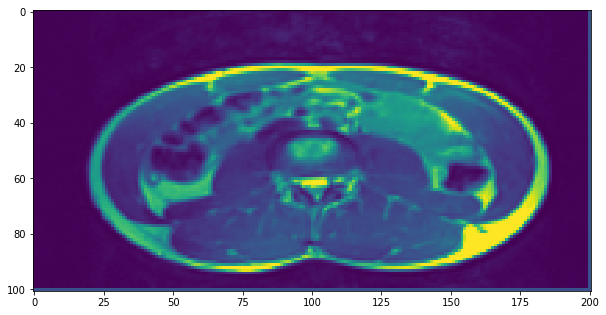

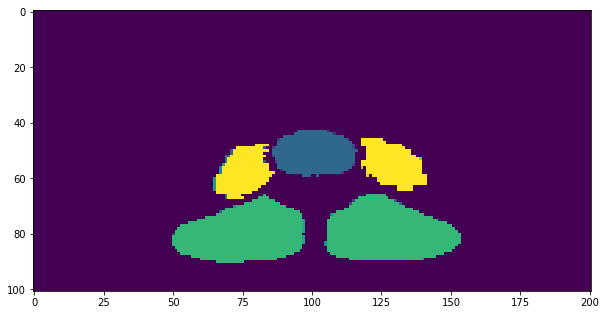

In [7]:
def reconstruct(y, neighSize=neighSize):
    a, b, c, d = y.shape
    reconstructed = np.zeros((a+c, b+d))
    for i in range(a):
        for j in range(b):
            reconstructed[i:i+neighSize, j:j+neighSize] = y[i, j]
    return reconstructed
index = np.random.randint(num_images)
print('image number %d'%index)
y_reconstructed = reconstruct(y_orig[index])
X_reconstructed = reconstruct(X_orig[index])
print(y_reconstructed.shape)
print(X_reconstructed.shape)
assert(y_reconstructed.shape == X_reconstructed.shape)
imshow(X_reconstructed)
plt.show()
imshow(y_reconstructed)

In [8]:
print("size of original X:", X_orig.shape)
N, ww, hh, dd1, dd2 = X_orig.shape
X = X_orig.reshape(N, ww * hh, dd1, dd2, 1)
y = y_orig.reshape(N, ww * hh, dd1, dd2, 1)
train_index = int(num_images * .8)
print(train_index)
X_train = X[:train_index].reshape(-1, dd1, dd2, 1)
y_train = y[:train_index].reshape(-1, dd1, dd2)[:, neighSize//2, neighSize//2]
print('size of trainig image: ', X_train.shape)
X_val = X[train_index:].reshape(-1, dd1, dd2, 1)
y_val = y[train_index:].reshape(-1, dd1, dd2)[:, neighSize//2, neighSize//2]
print('size of test image: ', X_val.shape)

size of original X: (20, 80, 180, 21, 21)
16
size of trainig image:  (230400, 21, 21, 1)
size of test image:  (57600, 21, 21, 1)


In [9]:

layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5

n_outputs = 4
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

output shape: 1620
Tensor("skip/concat:0", shape=(?, 21, 21, 21), dtype=float32)


In [10]:
def load_model(checkpoint_path):
    if os.path.isfile(checkpoint_path+'.data-00000-of-00001'):
        print("File already exists")
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [70]:
img_index = 18
with tf.Session() as sess:
    saver.restore(sess, './best')
    output = y_prob.eval(feed_dict={X_tf:X[img_index].reshape(-1, neighSize, neighSize, 1)}).reshape(ww, hh, n_outputs)
    #output = y_prob.eval(feed_dict={X_tf:X_train[train_indicies[:1000]]})


INFO:tensorflow:Restoring parameters from ./best


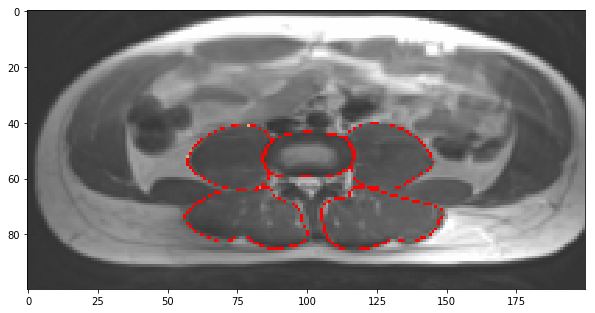

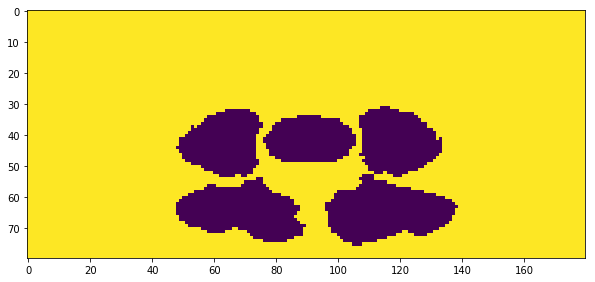

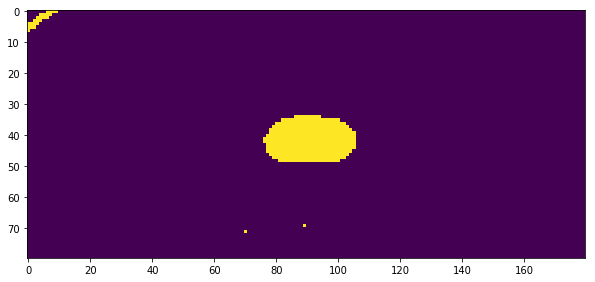

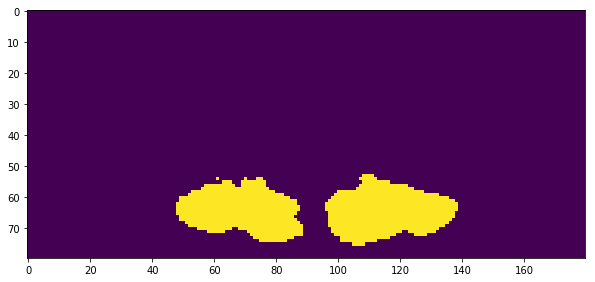

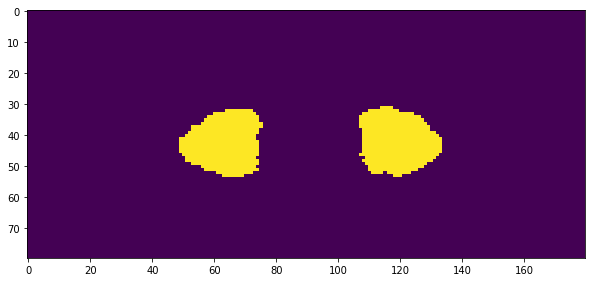

In [71]:
pylab.rcParams['figure.figsize'] = (10, 9)
muscle_dict = {}
distances = np.zeros((ww, hh))
kernel = np.ones((3, 3))
threshold = .4
half_length = neighSize // 2
reconstructed_img = cv2.resize(imgs[img_index], img_shape)
imshow(reconstructed_img)
plt.show()
for i in range(0, 4):
    #output_cleaned = cv2.erode(output[:, :, i], kernel)
    #output_cleaned = cv2.dilate(output_cleaned, kernel)
    imshow(output[:, :, i] > threshold)
    plt.show()
    #nonzeros = np.where(output_cleaned > threshold)
    #x_mean = int(np.mean(nonzeros[0]))
    #y_mean = int(np.mean(nonzeros[1]))
    #print(x_mean, y_mean)
    #cv2.circle(distances, (x_mean, y_mean), 5, 255, -1)

In [72]:
def divide_img(img, axis):
    w, h = img.shape
    output1 = np.zeros_like(img)
    output2 = np.zeros_like(img)
    if axis == 0:
        output1[:w//2, :] = img[:w//2, :]
        output2[w//2:, :] = img[w//2:, :]
    if axis == 1:
        output1[:, :h//2] = img[:, :h//2]
        output2[:, h//2:] = img[:, h//2:]
    return output1, output2
        
def get_midpoints(img):
    points = np.where(img)
    x_mean = np.mean(points[0])
    y_mean = np.mean(points[1])
    return np.array([x_mean, y_mean], dtype='int32')
new_output = output[3:-3, 3:-3, :] 
muscles = []
center_muscle = new_output[:, :, 1] > threshold
muscles.append(center_muscle)

bottom_muscle = new_output[:, :, 2] > threshold
bottom_left, bottom_right,  = divide_img(bottom_muscle, 1)
muscles.append(bottom_left)
muscles.append(bottom_right)
mid_muscle = new_output[:, :, 3] > threshold
mid_left, mid_right = divide_img(mid_muscle, 1)
muscles.append(mid_left)
muscles.append(mid_right)
centers = []
for muscle in muscles:
    centers.append(get_midpoints(muscle))
for center in centers:
    print(center)

[38 87]
[61 65]
[ 61 112]
[39 60]
[ 39 115]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[38 87]
[61 65]
[ 61 112]
[39 60]
[ 39 115]
0 60 74 112
distance:  30.610455730027933
distance:  7.211102550927978
distance:  22.02271554554524
distance:  22.47220505424423


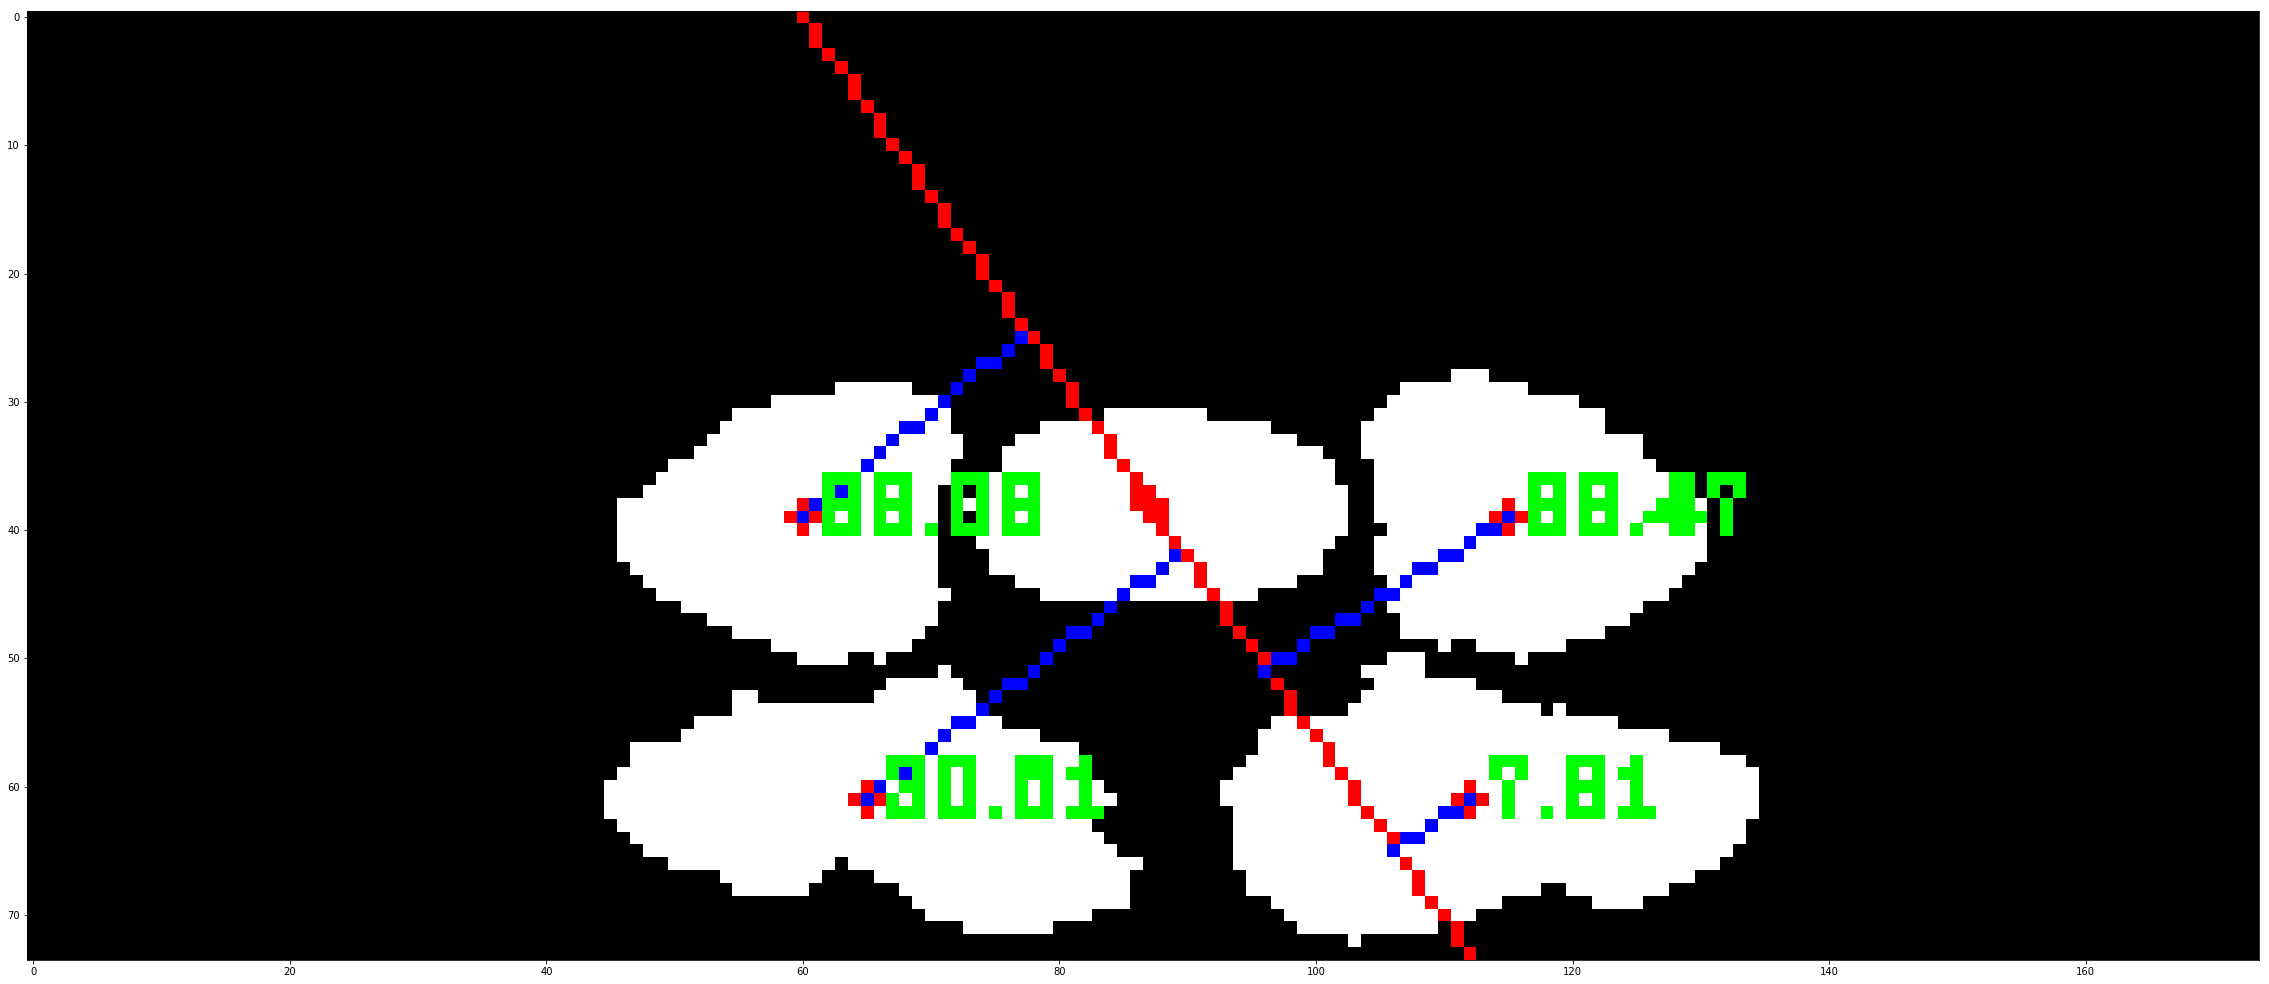

In [73]:
pylab.rcParams['figure.figsize'] = (40, 36)
#img = (output[:, :, 0] < .3).astype('uint8')
img = np.zeros_like(new_output[:, :, :3])
img[:, :, 0] = new_output[:, :, 0] < .3
img[:, :, 1] = new_output[:, :, 0] < .3
img[:, :, 2] = new_output[:, :, 0] < .3
for center in centers:
    print(center)
    cv2.circle(img, (center[1], center[0]), 1, 1)
degree = 45
w, h, c = img.shape

a = cos(degree / 180 * np.pi)
b = centers[0][1] - a * centers[0][0]
x0 = 0
y0 = int(b)
x1 = int(w)
y1 = int(a * w + b)
print(x0, y0, x1, y1)
cv2.line(img, (y0, x0), (y1, x1), 1)
for i in range(1, len(centers)):
    center = centers[i]
    b_prime = center[1] + center[0] / a
    x_prime = int(a * (b_prime - b) / (a*a + 1))
    y_prime = int(a * x_prime + b)
    distance = np.sqrt((center[0] - x_prime)**2 + (center[1] - y_prime)**2)
    print("distance: ", distance)
    cv2.line(img, (center[1], center[0]), (y_prime, x_prime), (0, 0, 10))
    cv2.putText(img,"%4.2f"%distance, (center[1]+1, center[0]+1), cv2.FONT_HERSHEY_COMPLEX, .2, (0, 10, 0))
imshow(img)

(80, 180)
(80, 180, 4)
Muscle number 1
matching:  365
false positive: 2.19%
false negative: 5.21%


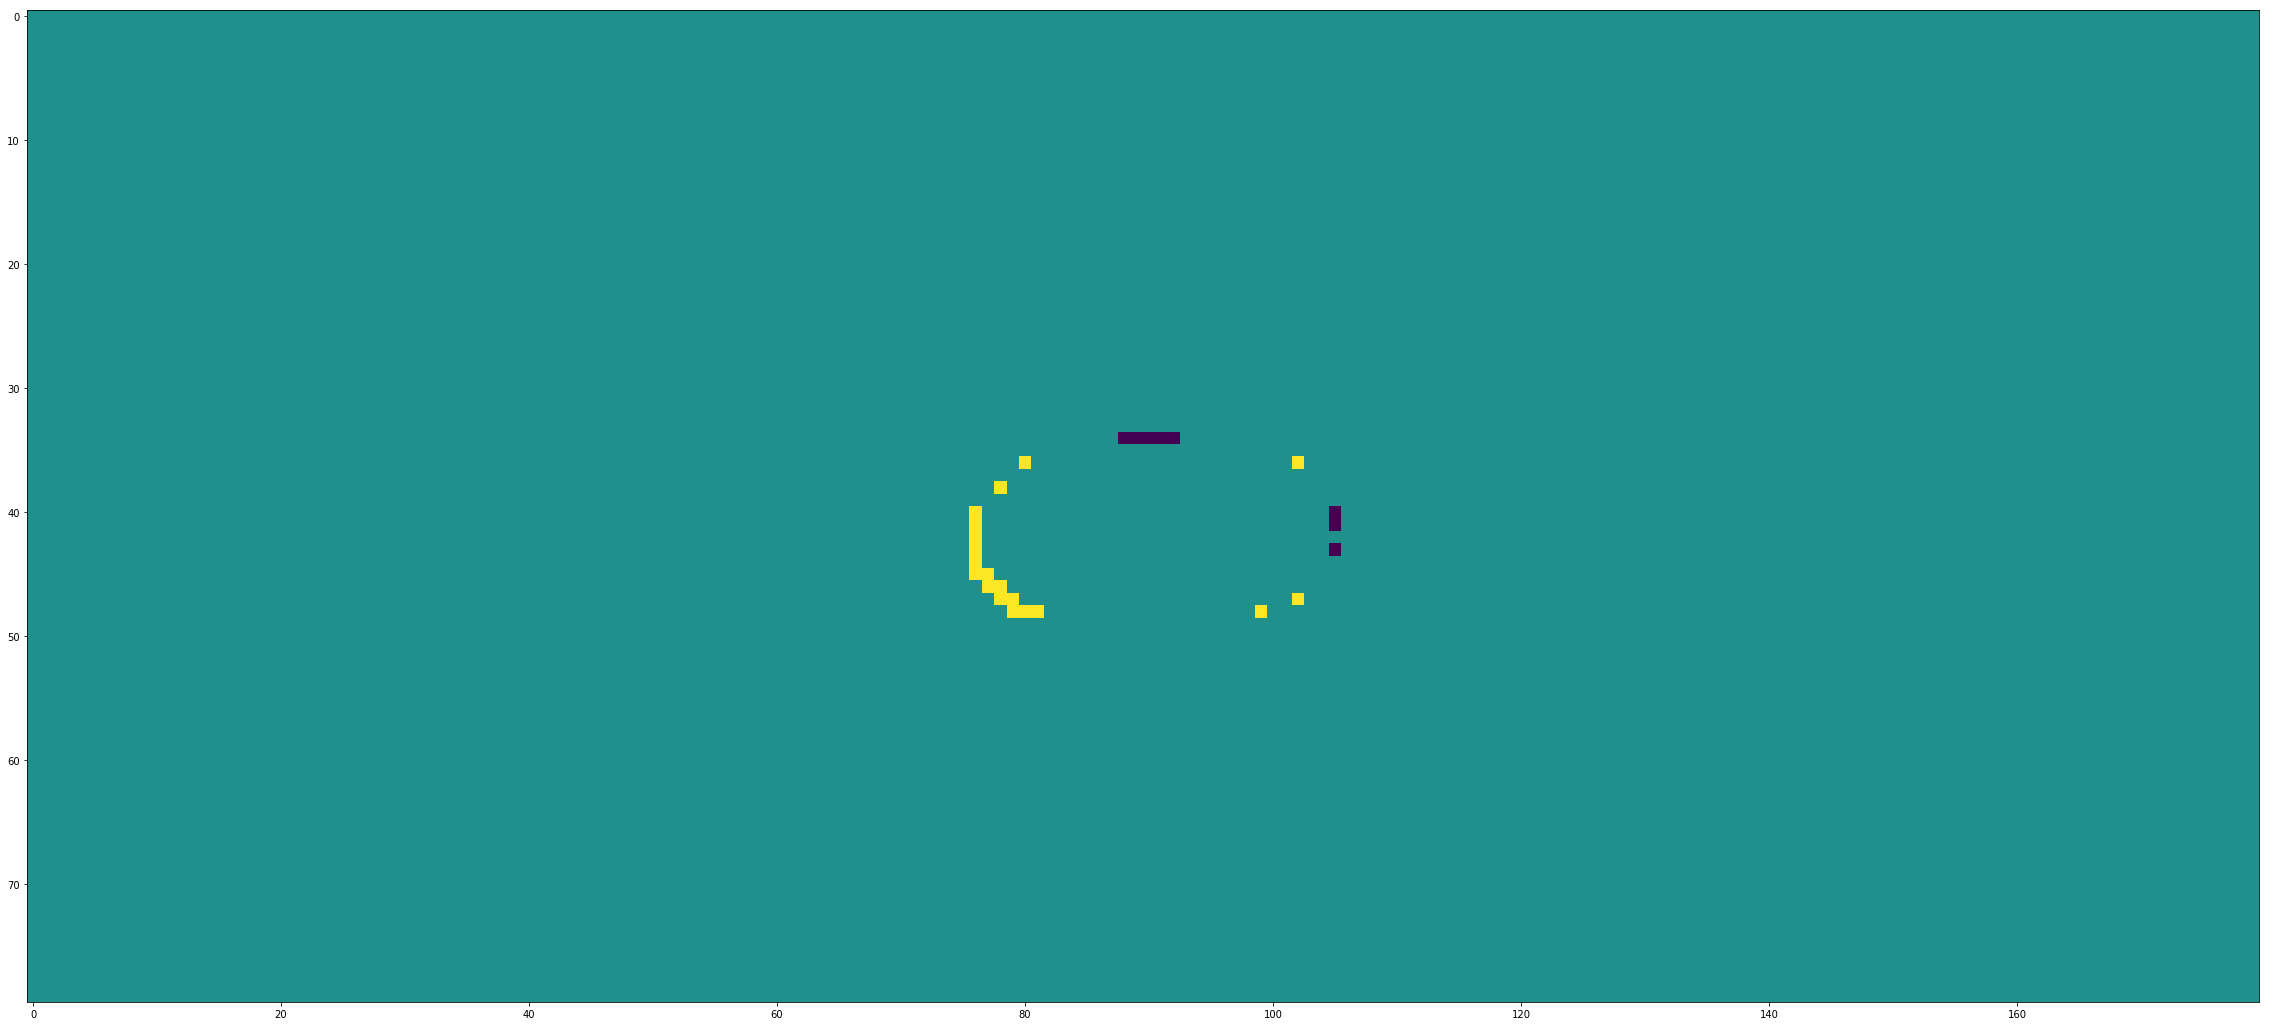

***************************************************
Muscle number 2
matching:  1230
false positive: 0.57%
false negative: 8.54%


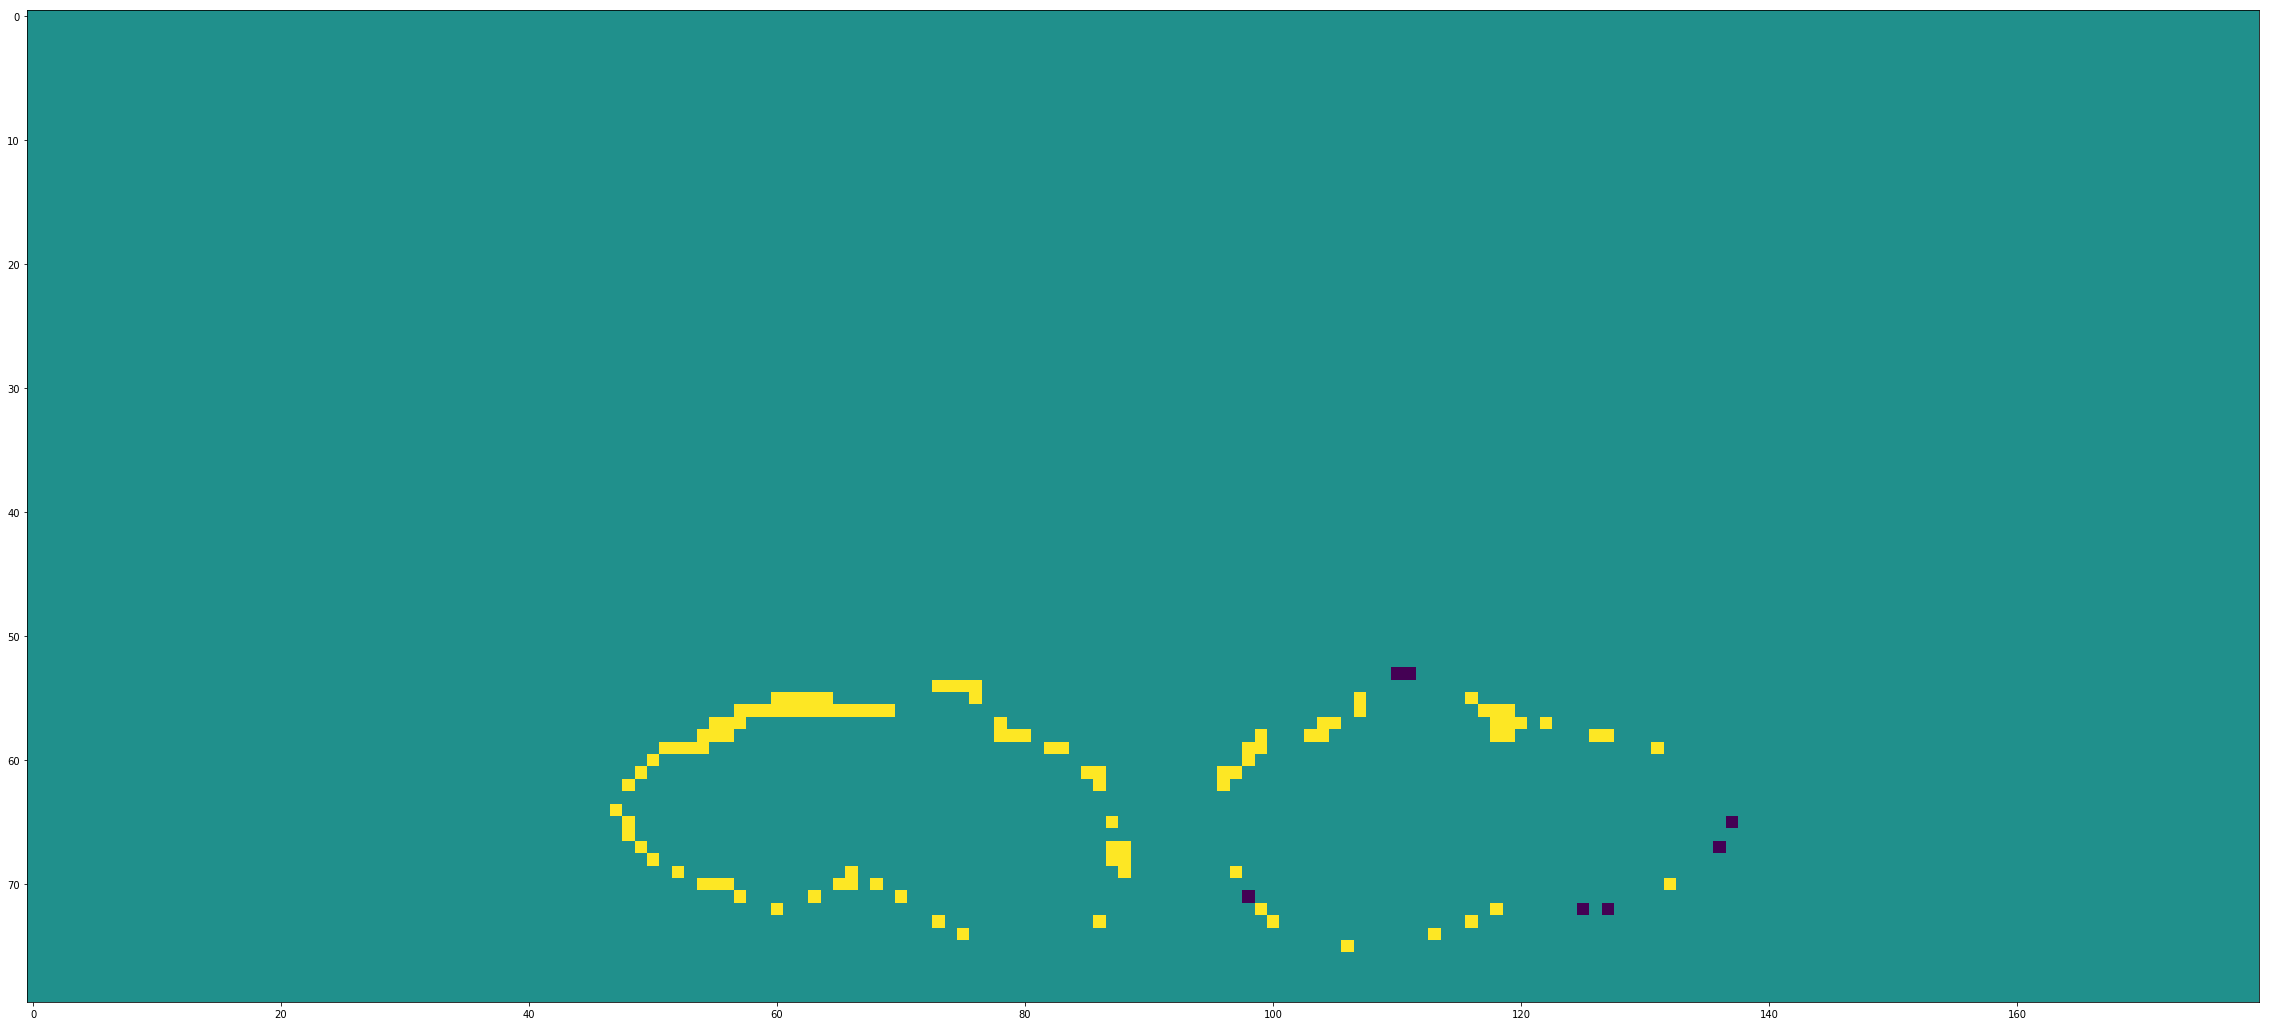

***************************************************
Muscle number 3
matching:  841
false positive: 2.26%
false negative: 7.61%


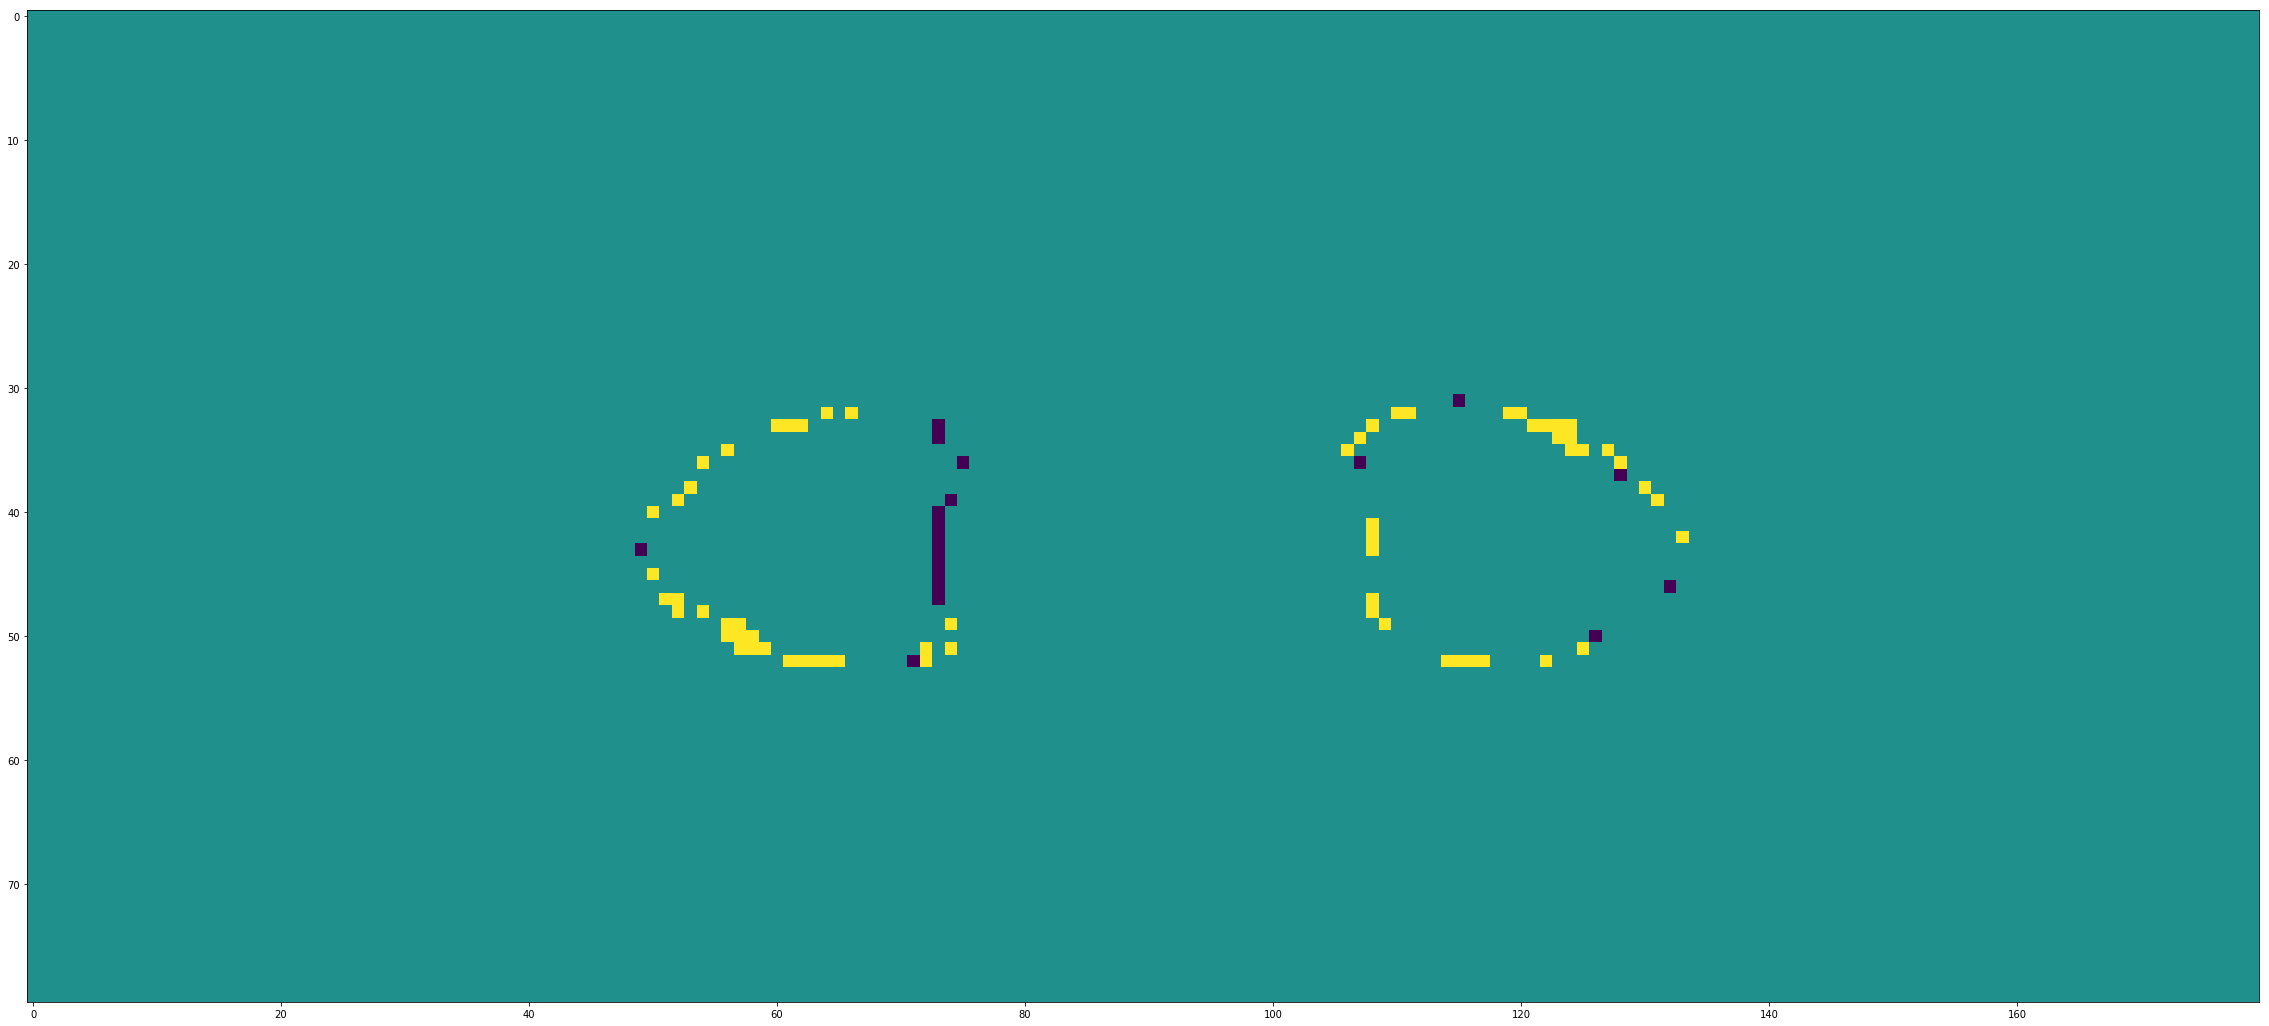

***************************************************


In [74]:
lbl = cv2.resize(labels[img_index], img_shape)[half_length:-half_length, half_length:-half_length]
print(lbl.shape)
print(output.shape)
for i in range(1, 4):
    zeros = np.zeros_like(output[:, :, 0])
    indices = np.where(lbl == i)
    zeros[indices] = 1
    diff = zeros - (output[:, :, i] > .8)
    print('Muscle number %d'%i)
    print("matching: ", len(indices[0]))
    print("false positive: %4.2f%%"%(100 * len(np.where(diff < 0)[0]) / len(indices[0])))
    print("false negative: %4.2f%%"%(100 * len(np.where(diff > 0)[0]) / len(indices[0])))
    imshow(diff)
    plt.show()
    print('***************************************************')

In [76]:
muscle_sizes = []
type_I_errors = []
type_II_errors = []
for img_index in range(16, 20):
    with tf.Session() as sess:
        saver.restore(sess, './best')
        output = y_prob.eval(feed_dict={X_tf:X[img_index].reshape(-1, neighSize, neighSize, 1)}).reshape(ww, hh, n_outputs)
        #output = y_prob.eval(feed_dict={X_tf:X_train[train_indicies[:1000]]})
    lbl = cv2.resize(labels[img_index], img_shape)[half_length:-half_length, half_length:-half_length]
    print(lbl.shape)
    print(output.shape)
    muscle_size = []
    type_I_error = []
    type_II_error = []
    for i in range(1, 4):
        zeros = np.zeros_like(output[:, :, 0])
        indices = np.where(lbl == i)
        zeros[indices] = 1
        diff = zeros - (output[:, :, i] > .8)
        muscle_size.append(len(indices[0]))
        type_I_error.append(len(np.where(diff < 0)[0]))
        type_II_error.append(len(np.where(diff > 0)[0]))
        print('Muscle number %d'%i)
        print("matching: ", len(indices[0]))
        print("false positive: %4.2f%%"%(100 * len(np.where(diff < 0)[0]) / len(indices[0])))
        print("false negative: %4.2f%%"%(100 * len(np.where(diff > 0)[0]) / len(indices[0])))
        print('***************************************************')   
    muscle_sizes.append(muscle_size)
    type_I_errors.append(type_I_error)
    type_II_errors.append(type_II_error)

INFO:tensorflow:Restoring parameters from ./best
(80, 180)
(80, 180, 4)
Muscle number 1
matching:  451
false positive: 4.21%
false negative: 4.21%
***************************************************
Muscle number 2
matching:  1405
false positive: 3.20%
false negative: 12.67%
***************************************************
Muscle number 3
matching:  709
false positive: 4.65%
false negative: 11.28%
***************************************************
INFO:tensorflow:Restoring parameters from ./best
(80, 180)
(80, 180, 4)
Muscle number 1
matching:  413
false positive: 2.42%
false negative: 6.54%
***************************************************
Muscle number 2
matching:  1557
false positive: 0.83%
false negative: 4.50%
***************************************************
Muscle number 3
matching:  798
false positive: 3.26%
false negative: 7.02%
***************************************************
INFO:tensorflow:Restoring parameters from ./best
(80, 180)
(80, 180, 4)
Muscle number 1
ma

In [78]:
muscles = np.array(muscle_sizes)
error_I = np.array(type_I_errors)
error_II = np.array(type_II_errors)

In [86]:
print(100 * error_I / muscles)

[[4.21286031 3.20284698 4.65444288]
 [2.42130751 0.83493899 3.25814536]
 [2.19178082 0.56910569 2.25921522]
 [2.97029703 0.48309179 1.64835165]]


In [87]:
print(100 * error_II / muscles)

[[ 4.21286031 12.66903915 11.28349788]
 [ 6.53753027  4.49582531  7.01754386]
 [ 5.20547945  8.53658537  7.60998811]
 [ 2.47524752  6.21118012  7.69230769]]
